<a href="https://colab.research.google.com/github/Guo-Weiqiang/Master-Project/blob/main/baseline(EEGNet).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
from torch.autograd import Variable
import torchvision.models as models
import torch.nn as nn
import matplotlib.pyplot as plt
from torch.utils.data import TensorDataset, DataLoader
import numpy as np
import torch.optim as optim
import pandas as pd
from torchsummary import summary
import os
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import random
from tqdm import tqdm

seed = 42
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
np.random.seed(seed)
random.seed(seed)
# torch.backends.cudnn.deterministic = True

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
SIGMA = 1

TODO
- literature study, online?
- template, num of pages
- train, val(s+t), test, MK-MMD
- experiments (TCA, DANN, Ours)
- Datasets acquisition
- t-sne
- multi-source
- task transfer

- t sne plot(s/t domain, 不同的类不同颜色的点)
- DaNN
- Dataset(SEED)
- multi-source
- task transfer

```
# This is formatted as code
```




# Loss Part




In [48]:
# 1. 成熟的数据集上，与主流的结果比（调整一下架构）
# 2. EEGNet 回归问题
# 3. 联合分布

# *. 可视化 t-sne 看看adapt之后的数据分布


# def MMD(source, target):
# 	"""
# 	mmd loss(linear)
# 	:param source: torch tensor: source data (Ds) with dimensions DxNs
# 	:param target: torch tensor: target data (Dt) with dimensons DxNt
# 	"""
# 	delta = source - target
# 	loss = torch.mean(torch.mm(delta, torch.transpose(delta, 0, 1)))

# 	return loss


# ref.
# 1. https://github.com/thuml/Xlearn/blob/master/pytorch/src/loss.py
# 2. https://github.com/MaterialsInformaticsDemo/DAN/blob/main/code/MK_MMD.py
# 3. https://github.com/thuml/Transfer-Learning-Library/blob/master/tllib/alignment/dan.py
def gaussian_kernel(source, target, kernel_mul=2.0, kernel_num=5, fix_sigma=None):
    # The simplest version: K = \beta * k where \beta=1
    n_samples_source = source.size(0)
    n_samples_target = target.size(0)
    total = torch.cat([source, target], dim=0)

    # Calculate the L2 distance matrix efficiently using matrix operations.
    total_xx = torch.sum(total * total, dim=1, keepdim=True)
    L2_distance = total_xx - 2.0 * torch.matmul(total, total.t()) + total_xx.t()
    if fix_sigma:
        bandwidth = fix_sigma
    else:
        # Set the average value of distance matrix as the bandwidth
        bandwidth = torch.sum(L2_distance.data) / (n_samples_source * n_samples_target - n_samples_source)

    bandwidth /= kernel_mul ** (kernel_num // 2) #
    # bandwidth range [2^{-4}*sigma, 2^4*sigma]
    bandwidth_list = [bandwidth * (kernel_mul ** (1 * i)) for i in range(kernel_num)]
    kernel_val = [torch.exp(-L2_distance / bandwidth_temp) for bandwidth_temp in bandwidth_list]

    return sum(kernel_val) # final gaussian kernel matrix



def MK_MMD(source, target, kernel_mul=2.0, kernel_num=5, fix_sigma=1.68): # fix_sigma from None to 1.68
    n_s, n_t = source.size(0), target.size(0)

    kernels = gaussian_kernel(source, target,
        kernel_mul=kernel_mul, kernel_num=kernel_num, fix_sigma=fix_sigma)

    # Efficiently calculate loss components using vectorized operations.
    SS = torch.triu(kernels[:n_s, :n_s], diagonal=1).sum() / float(n_s * n_s)
    TT = torch.triu(kernels[-n_t:, -n_t:], diagonal=1).sum() / float(n_t * n_t)
    ST = -kernels[:n_s, -n_t:].sum() / float(n_s * n_t)
    TS = -kernels[-n_t:, :n_s].sum() / float(n_s * n_t)

    loss = torch.abs(SS + TT - ST - TS)

    # return loss
    # loss1 = torch.triu(kernels[:batch_size, :batch_size], diagonal=1).sum() + torch.triu(kernels[batch_size:, batch_size:], diagonal=1).sum()
    # loss1 = loss1 / float(batch_size * batch_size / 2)

    # loss2 = -kernels[:batch_size, batch_size:].sum() - kernels[batch_size:, :batch_size].sum()
    # loss2 = loss2 / float(batch_size * batch_size)

    return loss

def MMD(Xs, Xt):
    ns, nt = Xs.size(0), Xt.size(0)

    # linear kernel version
    mmd_s = (Xs @ Xs.t()).sum() / (ns * ns)
    mmd_t = (Xt @ Xt.t()).sum() / (nt * nt)
    mmd_st = (Xs @ Xt.t()).sum() * 2.0 / (ns * nt)
    loss = mmd_s - mmd_st + mmd_t

    return torch.abs(loss)


def JMMD_Linear(source_list, target_list, kernel_muls=[2.0, 2.0, 2.0], kernel_nums=[5, 5, 1], fix_sigma_list=[None, None, 1.68]):
    batch_size = int(source_list[0].size()[0])
    layer_num = len(source_list)
    joint_kernels = None
    for i in range(layer_num):
        source = source_list[i]
        target = target_list[i]
        kernel_mul = kernel_muls[i]
        kernel_num = kernel_nums[i]
        fix_sigma = fix_sigma_list[i]
        kernels = gaussian_kernel(source, target,
            kernel_mul=kernel_mul, kernel_num=kernel_num, fix_sigma=fix_sigma)
        if joint_kernels is not None:
            joint_kernels = joint_kernels * kernels
        else:
            joint_kernels = kernels

    # Linear version
    # loss = 0
    # for i in range(batch_size):
    #     s1, s2 = i, (i+1) % batch_size
    #     t1, t2 = s1 + batch_size, s2 + batch_size
    #     loss += joint_kernels[s1, s2] + joint_kernels[t1, t2]
    #     loss -= joint_kernels[s1, t2] + joint_kernels[s2, t1]

    s1 = torch.arange(batch_size)
    s2 = (s1 + 1) % batch_size
    t1 = s1 + batch_size
    t2 = s2 + batch_size

    # Compute the loss in a vectorized way
    loss = torch.sum(joint_kernels[s1, s2] + joint_kernels[t1, t2] - joint_kernels[s1, t2] - joint_kernels[s2, t1])
    return torch.abs(loss) / float(batch_size) # loss might be negative



def _primal_kernel(Xs, Xt):
    Z = torch.cat((Xs.T, Xt.T), 1)  # Xs / Xt: batch_size * k
    return Z


def _linear_kernel(Xs, Xt):
    Z = torch.cat((Xs, Xt), 0)  # Xs / Xt: batch_size * k
    K = torch.mm(Z, Z.T)
    return K


def _rbf_kernel(Xs, Xt, sigma):
    Z = torch.cat((Xs, Xt), 0)
    ZZT = torch.mm(Z, Z.T)
    diag_ZZT = torch.diag(ZZT).unsqueeze(1)
    Z_norm_sqr = diag_ZZT.expand_as(ZZT)
    exponent = Z_norm_sqr - 2 * ZZT + Z_norm_sqr.T
    K = torch.exp(-exponent / (2 * sigma ** 2))
    return K

# functions to compute the marginal MMD with rbf kernel
def rbf_mmd(Xs, Xt, sigma):
    K = _rbf_kernel(Xs, Xt, sigma)
    m = Xs.size(0)  # assume Xs, Xt are same shape
    e = torch.cat((1 / m * torch.ones(m, 1), -1 / m * torch.ones(m, 1)), 0)
    M = e * e.T
    tmp = torch.mm(torch.mm(K.cpu(), M.cpu()), K.T.cpu())
    loss = torch.trace(tmp).cuda()
    return loss

# functions to compute rbf kernel JMMD
def rbf_jmmd(Xs, Ys, Xt, Yt0, sigma):
    K = _rbf_kernel(Xs, Xt, sigma)
    n = K.size(0)
    m = Xs.size(0)  # assume Xs, Xt are same shape
    e = torch.cat((1 / m * torch.ones(m, 1), -1 / m * torch.ones(m, 1)), 0)
    C = len(torch.unique(Ys))
    M = e * e.T * C
    for c in torch.unique(Ys):
        e = torch.zeros(n, 1)
        e[:m][Ys == c] = 1 / len(Ys[Ys == c])
        if len(Yt0[Yt0 == c]) == 0:
            e[m:][Yt0 == c] = 0
        else:
            e[m:][Yt0 == c] = -1 / len(Yt0[Yt0 == c])
        M = M + e * e.T
    M = M / torch.norm(M, p='fro')  # can reduce the training loss only for jmmd
    tmp = torch.mm(torch.mm(K.cpu(), M.cpu()), K.T.cpu())
    loss = torch.trace(tmp).cuda()
    return loss


def rbf_jpmmd(Xs, Ys, Xt, Yt0, sigma):
    K = _rbf_kernel(Xs, Xt, sigma)
    n = K.size(0)
    m = Xs.size(0)  # assume Xs, Xt are same shape
    M = 0
    for c in torch.unique(Ys):
        e = torch.zeros(n, 1)
        e[:m] = 1 / len(Ys)
        if len(Yt0[Yt0 == c]) == 0:
            e[m:] = 0
        else:
            e[m:] = -1 / len(Yt0)
        M = M + e * e.T
    tmp = torch.mm(torch.mm(K.cpu(), M.cpu()), K.T.cpu())
    loss = torch.trace(tmp).cuda()
    return loss


# functions to compute rbf kernel DJP-MMD
# def rbf_djpmmd(Xs, Ys, Xt, Yt0, sigma):
#     K = _rbf_kernel(Xs, Xt, sigma)
#     # K = _linear_kernel(Xs, Xt)  # bad performance
#     m = Xs.size(0)
#     C = 2  # len(tr.unique(Ys)), the number of classes

#     # For transferability
#     Ns = 1 / m * torch.zeros(m, C).scatter_(1, Ys.unsqueeze(1).cpu(), 1)
#     Nt = torch.zeros(m, C)
#     if len(torch.unique(Yt0)) == 1:
#         Nt = 1 / m * torch.zeros(m, C).scatter_(1, Yt0.unsqueeze(1).cpu(), 1)
#     Rmin_1 = torch.cat((torch.mm(Ns, Ns.T), torch.mm(-Ns, Nt.T)), 0)
#     Rmin_2 = torch.cat((torch.mm(-Nt, Ns.T), torch.mm(Nt, Nt.T)), 0)
#     Rmin = torch.cat((Rmin_1, Rmin_2), 1)

#     # For discriminability
#     Ms = torch.empty(m, (C - 1) * C)
#     Mt = torch.empty(m, (C - 1) * C)
#     for i in range(0, C):
#         idx = torch.arange((C - 1) * i, (C - 1) * (i + 1))
#         Ms[:, idx] = Ns[:, i].repeat(C - 1, 1).T
#         tmp = torch.arange(0, C)
#         Mt[:, idx] = Nt[:, tmp[tmp != i]]
#     Rmax_1 = torch.cat((torch.mm(Ms, Ms.T), torch.mm(-Ms, Mt.T)), 0)
#     Rmax_2 = torch.cat((torch.mm(-Mt, Ms.T), torch.mm(Mt, Mt.T)), 0)
#     Rmax = torch.cat((Rmax_1, Rmax_2), 1)
#     M = Rmin - 0.1 * Rmax
#     tmp = torch.mm(torch.mm(K.cpu(), M.cpu()), K.T.cpu())
#     loss = torch.trace(tmp.cuda())

#     return loss
def rbf_djpmmd(Xs, Ys, Xt, Yt0, sigma):
    # Assuming _rbf_kernel is already optimized and running on the correct device
    K = _rbf_kernel(Xs, Xt, sigma)
    m, C = Xs.size(0), 2  # Assuming number of classes C is fixed at 2

    # Ensure all tensors start on the same device, ideally on the GPU if available
    device = Xs.device
    Ns = torch.zeros(m, C, device=device).scatter_(1, Ys.unsqueeze(1), 1) / m
    Nt = torch.zeros(m, C, device=device)
    if len(torch.unique(Yt0)) == 1:
        Nt = torch.zeros(m, C, device=device).scatter_(1, Yt0.unsqueeze(1), 1) / m

    Rmin_1 = torch.cat((torch.mm(Ns, Ns.T), torch.mm(-Ns, Nt.T)), 0)
    Rmin_2 = torch.cat((torch.mm(-Nt, Ns.T), torch.mm(Nt, Nt.T)), 0)
    Rmin = torch.cat((Rmin_1, Rmin_2), 1)

    # For discriminability
    Ms = torch.empty(m, (C - 1) * C).to(device)
    Mt = torch.empty(m, (C - 1) * C).to(device)
    for i in range(0, C):
        idx = torch.arange((C - 1) * i, (C - 1) * (i + 1))
        Ms[:, idx] = Ns[:, i].repeat(C - 1, 1).T
        tmp = torch.arange(0, C)
        Mt[:, idx] = Nt[:, tmp[tmp != i]]
    Rmax_1 = torch.cat((torch.mm(Ms, Ms.T), torch.mm(-Ms, Mt.T)), 0)
    Rmax_2 = torch.cat((torch.mm(-Mt, Ms.T), torch.mm(Mt, Mt.T)), 0)
    Rmax = torch.cat((Rmax_1, Rmax_2), 1)
    M = Rmin - 0.1 * Rmax

    # Operate in the same device as K and M to avoid device transfers
    tmp = torch.mm(torch.mm(K, M), K.T).to(device)
    loss = torch.trace(tmp)

    return loss


# 1. Model Part

In [16]:


# ref.
# 1. https://github.com/agrija9/Deep-Unsupervised-Domain-Adaptation/blob/master/DDC/model.py
class EEGNet_ReLU(torch.nn.Module):
    def __init__(self, n_output):
        super(EEGNet_ReLU, self).__init__()
        self.firstConv = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=(1,51), stride=(1,1), padding=(0,25),bias=False),
            nn.BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
        self.depthwiseConv = nn.Sequential(
            nn.Conv2d(16, 32, kernel_size=(2,1), stride=(1,1), groups=8,bias=False),
            nn.BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            nn.ReLU(),
            nn.AvgPool2d(kernel_size=(1,4), stride=(1,4),padding=0),
            nn.Dropout(p=0.35)
        )
        self.separableConv = nn.Sequential(
            nn.Conv2d(32, 32, kernel_size=(1,15), stride=(1,1), padding=(0,7),bias=False),
            nn.BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            nn.ReLU(),
            nn.AvgPool2d(kernel_size=(1,8), stride=(1,8),padding=0),
            nn.Dropout(p=0.35),
            nn.Flatten()
        )
        self.classify = nn.Sequential(
            # nn.Linear(736, 256),
            # nn.ReLU(inplace=True),
            # nn.Linear(256, 256),
            # nn.ReLU(inplace=True),
            # nn.Linear(256, n_output, bias=True)

            # original classifier
            nn.Linear(736, n_output, bias=True)
        )

    def forward(self, x):
        out = self.firstConv(x)
        out = self.depthwiseConv(out)
        features = self.separableConv(out)
        out = self.classify(features)
        return out, features




class EEGNet_DDC(nn.Module):
    """
    Deep domain confusion network as defined in the paper:
    https://arxiv.org/abs/1412.3474
        :param num_classes: int
    """
    def __init__(self, num_classes):
        super(EEGNet_DDC, self).__init__()
        self.firstConv = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=(1,51), stride=(1,1), padding=(0,25),bias=False),
            nn.BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
        self.depthwiseConv = nn.Sequential(
            nn.Conv2d(16, 32, kernel_size=(2,1), stride=(1,1), groups=8,bias=False),
            nn.BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            nn.ReLU(),
            nn.AvgPool2d(kernel_size=(1,4), stride=(1,4),padding=0),
            nn.Dropout(p=0.35)
        )
        self.separableConv = nn.Sequential(
            nn.Conv2d(32, 32, kernel_size=(1,15), stride=(1,1), padding=(0,7),bias=False),
            nn.BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            nn.ReLU(),
            nn.AvgPool2d(kernel_size=(1,8), stride=(1,8),padding=0),
            nn.Dropout(p=0.35),
            nn.Flatten(),
        )

        # Ref. bottleneck in the paper
        # Our intuition is that a lower dimensional layer can be used to regularize the training of the source classiﬁer and prevent overﬁtting to the particular nuances of the source distribution
        self.bottleneck = nn.Sequential(
            nn.Linear(736, 256),
            nn.ReLU(inplace=True)
            # nn.Linear(256, 256),
            # nn.ReLU(inplace=True),
        )

        self.classifier = nn.Sequential(
            # nn.Flatten(),
            nn.Linear(256, num_classes, bias=True)
        )

        # # fc8 activation (final_classifier)
        # # self.fc8 = nn.Linear(736, num_classes)
        # self.classifier = nn.Sequential(
        #     nn.Linear(256, num_classes, bias=True)
        # )

    def forward(self, source, target):
        source = self.firstConv(source)
        source = self.depthwiseConv(source)
        features_src = self.separableConv(source)
        source = self.bottleneck(features_src)
        # print(source.shape)

        mmd_loss = 0
        target = self.firstConv(target)
        target = self.depthwiseConv(target)
        features_tar = self.separableConv(target)
        target = self.bottleneck(features_tar)
        # print(target.shape)
        mmd_loss += MMD(source, target)

        result = self.classifier(source)

        return result, mmd_loss, source, target


class EEGNet_DAN(nn.Module):
    """
    Deep domain confusion network as defined in the paper:
    https://arxiv.org/abs/1412.3474
        :param num_classes: int
    """
    def __init__(self, num_classes):
        super(EEGNet_DAN, self).__init__()
        self.firstConv = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=(1,51), stride=(1,1), padding=(0,25),bias=False),
            nn.BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
        self.depthwiseConv = nn.Sequential(
            nn.Conv2d(16, 32, kernel_size=(2,1), stride=(1,1), groups=8,bias=False),
            nn.BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            nn.ReLU(),
            nn.AvgPool2d(kernel_size=(1,4), stride=(1,4),padding=0),
            nn.Dropout(p=0.35)
        )
        self.separableConv = nn.Sequential(
            nn.Conv2d(32, 32, kernel_size=(1,15), stride=(1,1), padding=(0,7),bias=False),
            nn.BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            nn.ReLU(),
            nn.AvgPool2d(kernel_size=(1,8), stride=(1,8),padding=0),
            nn.Dropout(p=0.35),
            nn.Flatten()
        )

        # Ref. bottleneck in the paper
        # Our intuition is that a lower dimensional layer can be used to regularize the training of the source classiﬁer and prevent overﬁtting to the particular nuances of the source distribution
        self.bottleneck1 = nn.Sequential(
            nn.Linear(736, 256),
            nn.ReLU(inplace=True)

            # nn.Linear(256, 256),
            # nn.ReLU(inplace=True)
        )
        self.bottleneck2 = nn.Sequential(
            nn.Linear(256, 256),
            nn.ReLU(inplace=True)
        )

        self.classifier = nn.Sequential(
            # nn.Flatten(),
            nn.Linear(256, num_classes, bias=True)
        )

        # # fc8 activation (final_classifier)
        # # self.fc8 = nn.Linear(736, num_classes)
        # self.classifier = nn.Sequential(
        #     nn.Linear(256, num_classes, bias=True)
        # )

    def forward(self, source, target):
        source = self.firstConv(source)
        source = self.depthwiseConv(source)
        source = self.separableConv(source)
        f1_s = self.bottleneck1(source)
        f2_s = self.bottleneck2(f1_s)
        # print(source.shape)

        # if self.training:
        target = self.firstConv(target)
        target = self.depthwiseConv(target)
        target = self.separableConv(target)
        f1_t = self.bottleneck1(target)
        f2_t = self.bottleneck2(f1_t)
        mmd_loss1 = MMD(f1_s, f1_t)
        mmd_loss2 = MMD(f2_s, f2_t)

        result_s = self.classifier(f2_s)
        result_t = self.classifier(f2_t)
        mmd_loss3 = MMD(result_s, result_t) # P(Y)
        mmd_loss = 1 * mmd_loss1 + 1 * mmd_loss2 + 1 * mmd_loss3

        return result_s, mmd_loss, f2_s, f2_t



class EEGNet_JAN(nn.Module):
    """
    Deep domain confusion network as defined in the paper:
    https://arxiv.org/abs/1412.3474
        :param num_classes: int
    """
    def __init__(self, num_classes):
        super(EEGNet_JAN, self).__init__()
        self.firstConv = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=(1,51), stride=(1,1), padding=(0,25),bias=False),
            nn.BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
        self.depthwiseConv = nn.Sequential(
            nn.Conv2d(16, 32, kernel_size=(2,1), stride=(1,1), groups=8,bias=False),
            nn.BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            nn.ReLU(),
            nn.AvgPool2d(kernel_size=(1,4), stride=(1,4),padding=0),
            nn.Dropout(p=0.35)
        )
        self.separableConv = nn.Sequential(
            nn.Conv2d(32, 32, kernel_size=(1,15), stride=(1,1), padding=(0,7),bias=False),
            nn.BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            nn.ReLU(),
            nn.AvgPool2d(kernel_size=(1,8), stride=(1,8),padding=0),
            nn.Dropout(p=0.35),
            nn.Flatten()
        )

        # Ref. bottleneck in the paper
        # Our intuition is that a lower dimensional layer can be used to regularize the training of the source classiﬁer and prevent overﬁtting to the particular nuances of the source distribution
        self.bottleneck1 = nn.Sequential(
            nn.Linear(736, 256),
            nn.ReLU(inplace=True)

            # nn.Linear(256, 256),
            # nn.ReLU(inplace=True)
        )
        self.bottleneck2 = nn.Sequential(
            nn.Linear(256, 256),
            nn.ReLU(inplace=True)
        )

        self.classifier = nn.Sequential(
            nn.Linear(256, num_classes, bias=True)
        )

        # # fc8 activation (final_classifier)
        # # self.fc8 = nn.Linear(736, num_classes)
        # self.classifier = nn.Sequential(
        #     nn.Linear(256, num_classes, bias=True)
        # )

    def forward(self, source, target):
        source = self.firstConv(source)
        source = self.depthwiseConv(source)
        source = self.separableConv(source)
        f1_s = self.bottleneck1(source)
        f2_s = self.bottleneck2(f1_s)
        # print(source.shape)

        # if self.training:
        target = self.firstConv(target)
        target = self.depthwiseConv(target)
        target = self.separableConv(target)
        f1_t = self.bottleneck1(target)
        f2_t = self.bottleneck2(f1_t)
        result_s = self.classifier(f2_s)
        result_t = self.classifier(f2_t)

        source_list = [f1_s, f2_s, result_s]
        target_list = [f1_t, f2_t, result_t]
        mmd_loss = JMMD_Linear(source_list, target_list) # P(Y)

        return result_s, mmd_loss, f2_s, f2_t


class EEGNet_DA1(torch.nn.Module):
    def __init__(self, n_output):
        super(EEGNet_DA1, self).__init__()
        self.firstConv = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=(1,51), stride=(1,1), padding=(0,25),bias=False),
            nn.BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
        self.depthwiseConv = nn.Sequential(
            nn.Conv2d(16, 32, kernel_size=(2,1), stride=(1,1), groups=8,bias=False),
            nn.BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            nn.ReLU(),
            nn.AvgPool2d(kernel_size=(1,4), stride=(1,4),padding=0),
            nn.Dropout(p=0.35)
        )
        self.separableConv = nn.Sequential(
            nn.Conv2d(32, 32, kernel_size=(1,15), stride=(1,1), padding=(0,7),bias=False),
            nn.BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            nn.ReLU(),
            nn.AvgPool2d(kernel_size=(1,8), stride=(1,8),padding=0),
            nn.Dropout(p=0.35),
            nn.Flatten()
        )
        self.bottleneck = nn.Sequential(
            nn.Linear(736, 256),
            nn.ReLU(inplace=True)
        )
        self.classify = nn.Sequential(
            # original classifier
            nn.Linear(256, n_output, bias=True)
        )

    def forward(self, source, target):
        out = self.firstConv(source)
        out = self.depthwiseConv(out)
        out = self.separableConv(out)
        features_src = self.bottleneck(out)
        out = self.classify(features_src)

        target = self.firstConv(target)
        target = self.depthwiseConv(target)
        target = self.separableConv(target)
        features_tar = self.bottleneck(target)

        return out, features_src, features_tar

# 2. Loss Part

# 3. Evaluation Part

## 3.1 Data Import

In [4]:
import numpy as np


def read_bci_data():
    """
    two subjects: S4b, X11b
    The experiment consists of 3 sessions for each subject. Each session consists of 4 to 9 runs
    """
    S4b_train = np.load('drive/MyDrive/EEGNet/S4b_train.npz')
    X11b_train = np.load('drive/MyDrive/EEGNet/X11b_train.npz')
    S4b_test = np.load('drive/MyDrive/EEGNet/S4b_test.npz')
    X11b_test = np.load('drive/MyDrive/EEGNet/X11b_test.npz')

    source_data = np.concatenate((S4b_train['signal'], S4b_test['signal']), axis=0)
    source_label = np.concatenate((S4b_train['label'], S4b_test['label']), axis=0)
    target_data = np.concatenate((X11b_train['signal'], X11b_test['signal']), axis=0)
    target_label = np.concatenate((X11b_train['label'], X11b_test['label']), axis=0)

    source_label = source_label - 1
    target_label = target_label - 1
    source_data = np.transpose(np.expand_dims(source_data, axis=1), (0, 1, 3, 2))
    target_data = np.transpose(np.expand_dims(target_data, axis=1), (0, 1, 3, 2))

    mask = np.where(np.isnan(source_data))
    source_data[mask] = np.nanmean(source_data)


    mask = np.where(np.isnan(target_data))
    target_data[mask] = np.nanmean(target_data)


    source_data = torch.from_numpy(source_data).float()
    target_data = torch.from_numpy(target_data).float()
    source_label = torch.tensor(source_label, dtype=torch.long)
    target_label = torch.tensor(target_label, dtype=torch.long)
    val_data = target_data
    val_label = target_label

    print(source_data.shape, source_label.shape, val_data.shape, val_label.shape, target_data.shape, target_label.shape)

    return source_data, source_label, val_data, val_label, target_data, target_label


source_data, source_label, val_data, val_label, target_data, target_label = read_bci_data()


torch.Size([1080, 1, 2, 750]) torch.Size([1080]) torch.Size([1080, 1, 2, 750]) torch.Size([1080]) torch.Size([1080, 1, 2, 750]) torch.Size([1080])


### T-SNE Visualization

In [5]:
s = source_label.numpy()
t = val_label.numpy()
print(s.shape, t.shape)

unique_values, counts = np.unique(s, return_counts=True)

for value, count in zip(unique_values, counts):
    print(f"Value: {value}, Count: {count}")

unique_values, counts = np.unique(t, return_counts=True)

for value, count in zip(unique_values, counts):
    print(f"Value: {value}, Count: {count}")

source_class0_index = np.where(s == 0.0)
source_class1_index = np.where(s == 1.0)
target_class0_index = np.where(t == 0.0)
target_class1_index = np.where(t == 1.0)

print(len(source_class0_index[0]), len(source_class1_index[0]), len(target_class0_index[0]), len(target_class1_index[0]))

(1080,) (1080,)
Value: 0, Count: 540
Value: 1, Count: 540
Value: 0, Count: 540
Value: 1, Count: 540
540 540 540 540


In [6]:
print(source_class0_index)

(array([   2,    6,    8,   10,   12,   13,   14,   15,   17,   18,   21,
         23,   24,   27,   30,   33,   35,   38,   39,   42,   44,   45,
         46,   47,   49,   51,   54,   55,   56,   57,   60,   62,   64,
         69,   72,   73,   75,   77,   78,   79,   81,   84,   85,   87,
         91,   95,   97,   98,   99,  100,  102,  104,  107,  110,  111,
        113,  114,  116,  125,  128,  129,  131,  133,  134,  136,  137,
        138,  139,  140,  141,  146,  150,  152,  155,  156,  157,  160,
        163,  164,  165,  166,  167,  169,  171,  176,  179,  181,  184,
        185,  186,  187,  188,  189,  190,  192,  194,  195,  196,  199,
        203,  204,  206,  207,  208,  215,  217,  218,  219,  226,  227,
        228,  229,  231,  232,  234,  236,  241,  245,  246,  247,  250,
        254,  255,  260,  261,  263,  264,  266,  267,  270,  274,  277,
        280,  282,  283,  285,  286,  287,  291,  292,  294,  295,  296,
        297,  300,  302,  304,  306,  307,  314,  

(1080, 1500) (1080, 1500)
(2160, 1500)
(1080, 2) (1080, 2)
(540, 2) (540, 2) (540, 2) (540, 2)


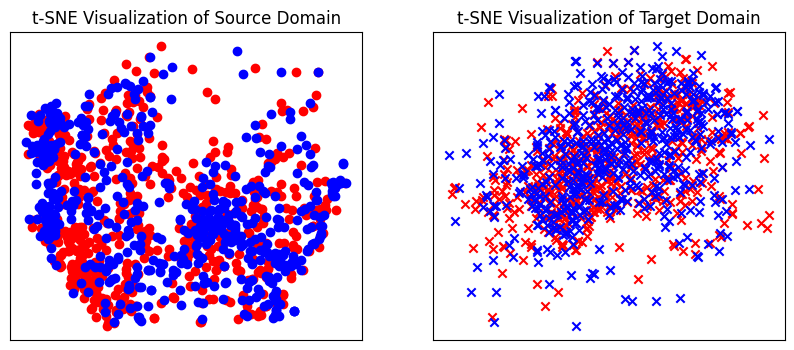

In [7]:
def tsne_visulization(source_data: np.ndarray, target_data: np.ndarray, path: str, format: str = 'jpg'):
    s = source_data.copy()
    t = target_data.copy()
    s = s.reshape(source_data.shape[0], -1)
    t = t.reshape(target_data.shape[0], -1)
    print(s.shape, t.shape)
    combined_dataset = np.vstack((s, t))
    print(combined_dataset.shape)

    perplexity = 30
    n_dimensions = 2

    tsne = TSNE(n_components=n_dimensions, perplexity=perplexity, random_state=42)
    tsne_result = tsne.fit_transform(combined_dataset)
    tsne_source_data = tsne_result[:s.shape[0]]
    tsne_target_data = tsne_result[s.shape[0]:]
    print(tsne_source_data.shape, tsne_target_data.shape)

    source_data_class0 = tsne_source_data[source_class0_index]
    source_data_class1 = tsne_source_data[source_class1_index]
    target_data_class0 = tsne_target_data[target_class0_index]
    target_data_class1 = tsne_target_data[target_class1_index]
    print(source_data_class0.shape, source_data_class1.shape, target_data_class0.shape, target_data_class1.shape)


    plt.figure(figsize=(10, 4))
    plt.subplot(121)
    plt.scatter(source_data_class0[:, 0], source_data_class0[:, 1], c='r', marker='o', label='source domain class 0')
    plt.scatter(source_data_class1[:, 0], source_data_class1[:, 1], c='b', marker='o', label='source domain class 1')
    plt.title('t-SNE Visualization of Source Domain')
    # plt.xlabel('t-SNE Dimension 1')
    # plt.ylabel('t-SNE Dimension 2')
    plt.xticks([])
    plt.yticks([])
    # plt.legend()

    plt.subplot(122)
    plt.scatter(target_data_class0[:, 0], target_data_class0[:, 1], c='r', marker='x', label='target domain class 0')
    plt.scatter(target_data_class1[:, 0], target_data_class1[:, 1], c='b', marker='x', label='target domain class 1')
    plt.title('t-SNE Visualization of Target Domain')
    # plt.xlabel('t-SNE Dimension 1')
    # plt.ylabel('t-SNE Dimension 2')
    plt.xticks([])
    plt.yticks([])
    # plt.legend()

    path = path + '.' + format
    plt.savefig(path, format=format)
    plt.show()

tsne_visulization(source_data.numpy(), val_data.numpy(), path='test.eps')

## 3.2 without DA

torch.Size([1080, 1, 2, 750]) torch.Size([1080]) torch.Size([1080, 1, 2, 750]) torch.Size([1080]) torch.Size([1080, 1, 2, 750]) torch.Size([1080])


  0%|          | 1/500 [00:00<01:28,  5.65it/s]

Model saved at epoch 1 with validation accuracy: 0.5000


  1%|          | 5/500 [00:00<00:54,  9.13it/s]

Model saved at epoch 3 with validation accuracy: 0.5009
Model saved at epoch 4 with validation accuracy: 0.5148
Model saved at epoch 5 with validation accuracy: 0.5287


  2%|▏         | 8/500 [00:00<00:50,  9.68it/s]

Model saved at epoch 6 with validation accuracy: 0.5593
Model saved at epoch 7 with validation accuracy: 0.5713
Model saved at epoch 8 with validation accuracy: 0.5722


  2%|▏         | 10/500 [00:01<00:49,  9.96it/s]

Model saved at epoch 9 with validation accuracy: 0.5796


100%|██████████| 500/500 [00:51<00:00,  9.64it/s]


the best accuracy is:  0.5796296296296296
(1080, 736) (1080, 736)
(2160, 736)
(1080, 2) (1080, 2)
(540, 2) (540, 2) (540, 2) (540, 2)


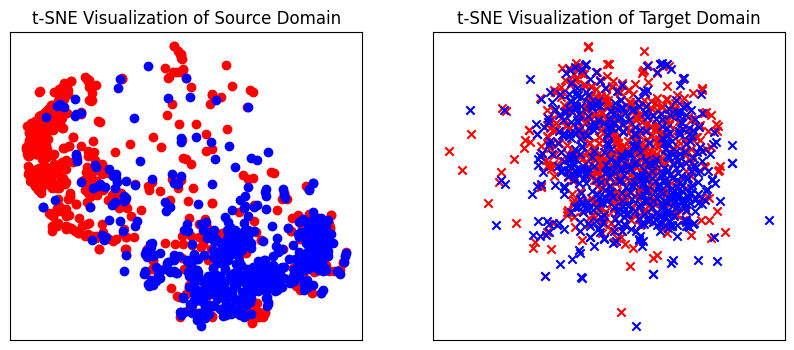

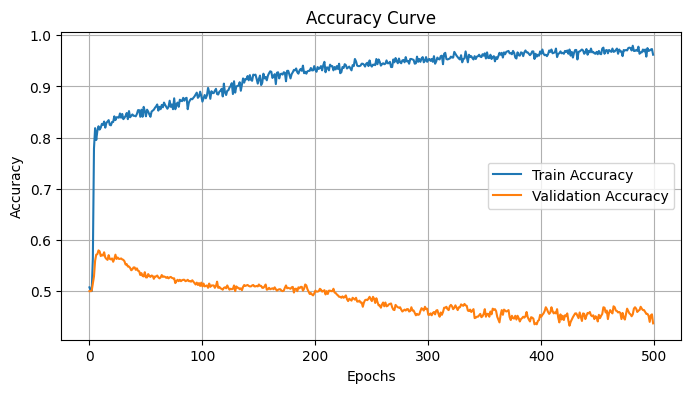

In [ ]:
def test(dataloader, model):
    model.eval()
    size = len(dataloader.dataset)
    correct = 0

    with torch.no_grad():
        for x, y in dataloader:
            x, y = x.to(DEVICE), y.to(DEVICE)
            y_pred, features = model(x)
            correct += (torch.max(y_pred, 1)[1] == y).sum().item()

    accuracy = correct / size

    return accuracy, features



def train(source_data, source_label, val_data, val_label, target_data, target_label, batch_size=1080, epochs=500, lr=1e-3):
    train_dataset = TensorDataset(source_data, source_label)
    val_dataset = TensorDataset(val_data, val_label)

    train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(dataset=val_dataset, batch_size=batch_size, shuffle=True)

    model = EEGNet_ReLU(n_output=2)
    loss_fn = nn.CrossEntropyLoss()

    # optimizer = optim.Adam(model.parameters(),lr = lr)
    optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.5, weight_decay=5e-4)

    model.to(DEVICE)
    # summary(model.cuda(),(1,2,750))

    loss_history = []
    train_accuracy_history = []
    val_accuracy_history = []
    test_accuracy_history = []

    best_acc = 0

    for epoch in tqdm(range(epochs)):
        model.train()

        running_loss = 0.0
        correct = 0
        total = 0

        for batch, (x, y) in enumerate(train_loader):
            optimizer.zero_grad()

            x, y = x.to(DEVICE), y.to(DEVICE)
            y_pred, source_features = model(x)

            loss = loss_fn(y_pred, y)

            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            correct += (torch.max(y_pred,1)[1] == y).sum().item()
            total += y.size(0)


        train_accuracy = correct / total
        train_accuracy_history.append(train_accuracy)

        val_accuracy, val_features = test(val_loader, model)
        if val_accuracy > best_acc:
            best_acc = val_accuracy
            torch.save(model.state_dict(), 'EEGNet_best_model.pth')
            print(f'Model saved at epoch {epoch+1} with validation accuracy: {val_accuracy:.4f}')

        val_accuracy_history.append(val_accuracy)

        # print("epochs:",epoch,"loss:",loss.item(),"D_s Accuracy:",train_accuracy,"validation accuracy: ", val_accuracy, "D_t Accuracy:",test_accuracy)

    print("the best accuracy is: ", best_acc)
    model.load_state_dict(torch.load("EEGNet_best_model.pth"))
    _, source_features = model(source_data.to(DEVICE))
    _, val_features = model(val_data.to(DEVICE))
    tsne_visulization(source_features.cpu().detach().numpy(), val_features.cpu().detach().numpy(), path='original.jpg')


    plt.figure(figsize=(8, 4))
    # plt.plot(loss_history, label="Loss")
    plt.plot(train_accuracy_history, label='Train Accuracy')
    plt.plot(val_accuracy_history, label='Validation Accuracy')
    # plt.plot(test_accuracy_history, label='Test Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.title('Accuracy Curve')
    plt.grid(True)
    plt.show()



source_data, source_label, val_data, val_label, target_data, target_label = read_bci_data()
train(source_data, source_label, val_data, val_label, target_data, target_label, batch_size=1080, epochs=500, lr=1e-1)

## 3.3 With DA

In [63]:
def test(data, label, model):
    model.eval()
    with torch.no_grad():
        data, label = data.to(DEVICE), label.to(DEVICE)
        pred, _, _, _ = model(data, data)

        correct_cnt = (torch.max(pred, 1)[1] == label).sum().item()
        sample_cnt = data.shape[0]
        accuracy = correct_cnt / sample_cnt

    return accuracy

def train(model, source_data, source_label, val_data, val_label, target_data, target_label, lambda_factor=0.5, batch_size=1080, epochs=500, lr=1e-3, path='test', format='jpg'):
    train_dataset = TensorDataset(source_data, source_label)
    val_dataset = TensorDataset(val_data, val_label)

    train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(dataset=val_dataset, batch_size=batch_size, shuffle=True)

    loss_fn = nn.CrossEntropyLoss()

    optimizer = optim.Adam(model.parameters(),lr = lr)
    # optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.5, weight_decay=5e-4)

    model.to(DEVICE)

    clf_loss_history = []
    mmd_loss_history = []
    train_accuracy_history = []
    val_accuracy_history = []
    test_accuracy_history = []

    best_acc = 0

    for epoch in tqdm(range(epochs)):
        model.train()

        optimizer.zero_grad()

        source_data, source_label = source_data.to(DEVICE), source_label.to(DEVICE)
        target_data = target_data.to(DEVICE)
        val_data = val_data.to(DEVICE)

        train_target_data = val_data
        train_target_data = train_target_data.to(DEVICE)

        preds, mmd_loss, source, val = model(source_data, train_target_data)

        # compute loss
        clf_loss = loss_fn(preds, source_label)
        loss = clf_loss + lambda_factor * mmd_loss

        clf_loss_history.append(loss.item())
        mmd_loss_history.append(mmd_loss.item())

        correct_cnt = (torch.max(preds, 1)[1]== source_label).sum().item()
        accuracy = correct_cnt / source_data.shape[0]
        train_accuracy_history.append(accuracy)

        loss.backward()
        optimizer.step()

        val_accuracy = test(val_data, val_label, model)
        val_accuracy_history.append(val_accuracy)
        if val_accuracy > best_acc:
            best_acc = val_accuracy
            torch.save(model.state_dict(), 'DA_best_model.pth')
            print(f'Model saved at epoch {epoch+1} with validation accuracy: {val_accuracy:.4f}')


    print("the best accuracy is: ", best_acc)
    model.load_state_dict(torch.load("DA_best_model.pth"))
    _, _, source_features, val_features = model(source_data.to(DEVICE), val_data.to(DEVICE))
    tsne_visulization(source_features.cpu().detach().numpy(), val_features.cpu().detach().numpy(), path='original.jpg')

    plt.figure(figsize=(16, 4))
    plt.subplot(1, 2, 1)
    # plt.plot(loss_history, label="Loss")
    plt.plot(train_accuracy_history, label='Train Accuracy')
    plt.plot(val_accuracy_history, label='Validation Accuracy')
    plt.plot(test_accuracy_history, label='Test Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.title('Accuracy Curve')
    plt.grid(True)
    # plt.show()


    plt.subplot(1, 2, 2)
    plt.plot(clf_loss_history, label="CLF Loss")
    plt.plot(mmd_loss_history, label='MMD Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Loss Curve')
    plt.grid(True)
    plt.show()



## DDC

In [68]:
model = EEGNet_DDC(num_classes=2)
source_data, source_label, val_data, val_label, target_data, target_label = read_bci_data()
train(model, source_data, source_label, val_data, val_label, target_data, target_label, lambda_factor=20, batch_size=1080, epochs=500, lr=1e-2, path='DDC.jpg')

torch.Size([1080, 1, 2, 750]) torch.Size([1080]) torch.Size([1080, 1, 2, 750]) torch.Size([1080]) torch.Size([1080, 1, 2, 750]) torch.Size([1080])


  0%|          | 2/500 [00:00<01:44,  4.77it/s]

Model saved at epoch 1 with validation accuracy: 0.5000


  1%|          | 4/500 [00:00<01:29,  5.56it/s]

Model saved at epoch 3 with validation accuracy: 0.5028


  1%|▏         | 7/500 [00:01<01:23,  5.93it/s]

Model saved at epoch 6 with validation accuracy: 0.5074
Model saved at epoch 7 with validation accuracy: 0.5102


 13%|█▎        | 65/500 [00:10<01:11,  6.11it/s]

Model saved at epoch 64 with validation accuracy: 0.5148
Model saved at epoch 65 with validation accuracy: 0.5157


 15%|█▍        | 74/500 [00:12<01:09,  6.11it/s]

Model saved at epoch 73 with validation accuracy: 0.5167
Model saved at epoch 74 with validation accuracy: 0.5185


 15%|█▌        | 76/500 [00:12<01:09,  6.09it/s]

Model saved at epoch 75 with validation accuracy: 0.5241


 16%|█▌        | 78/500 [00:12<01:09,  6.06it/s]

Model saved at epoch 77 with validation accuracy: 0.5259
Model saved at epoch 78 with validation accuracy: 0.5296


 17%|█▋        | 87/500 [00:14<01:08,  6.05it/s]

Model saved at epoch 86 with validation accuracy: 0.5306
Model saved at epoch 87 with validation accuracy: 0.5463


 19%|█▉        | 96/500 [00:15<01:06,  6.07it/s]

Model saved at epoch 95 with validation accuracy: 0.5565


 20%|██        | 101/500 [00:16<01:06,  6.02it/s]

Model saved at epoch 100 with validation accuracy: 0.5639
Model saved at epoch 101 with validation accuracy: 0.5676


 22%|██▏       | 109/500 [00:17<01:04,  6.03it/s]

Model saved at epoch 108 with validation accuracy: 0.5750


 23%|██▎       | 116/500 [00:19<01:03,  6.02it/s]

Model saved at epoch 115 with validation accuracy: 0.5769


 25%|██▌       | 126/500 [00:20<01:03,  5.92it/s]

Model saved at epoch 125 with validation accuracy: 0.5806
Model saved at epoch 126 with validation accuracy: 0.5815


 26%|██▌       | 128/500 [00:21<01:02,  5.94it/s]

Model saved at epoch 127 with validation accuracy: 0.5861


 27%|██▋       | 137/500 [00:22<01:00,  6.01it/s]

Model saved at epoch 136 with validation accuracy: 0.5907


 28%|██▊       | 140/500 [00:23<00:59,  6.03it/s]

Model saved at epoch 139 with validation accuracy: 0.5972


 38%|███▊      | 192/500 [00:31<00:51,  5.93it/s]

Model saved at epoch 191 with validation accuracy: 0.5981


 39%|███▉      | 196/500 [00:32<00:51,  5.94it/s]

Model saved at epoch 195 with validation accuracy: 0.6009


 43%|████▎     | 214/500 [00:35<00:48,  5.94it/s]

Model saved at epoch 213 with validation accuracy: 0.6019


 47%|████▋     | 237/500 [00:39<00:44,  5.98it/s]

Model saved at epoch 236 with validation accuracy: 0.6028


 48%|████▊     | 240/500 [00:39<00:43,  5.95it/s]

Model saved at epoch 239 with validation accuracy: 0.6046


 50%|████▉     | 248/500 [00:41<00:42,  5.99it/s]

Model saved at epoch 247 with validation accuracy: 0.6056


 51%|█████     | 254/500 [00:42<00:41,  5.97it/s]

Model saved at epoch 253 with validation accuracy: 0.6102
Model saved at epoch 254 with validation accuracy: 0.6130


 88%|████████▊ | 442/500 [01:13<00:09,  6.04it/s]

Model saved at epoch 441 with validation accuracy: 0.6194


 94%|█████████▍| 472/500 [01:18<00:04,  6.03it/s]


KeyboardInterrupt: ignored

## with DA (DAN)

torch.Size([1080, 1, 2, 750]) torch.Size([1080]) torch.Size([1080, 1, 2, 750]) torch.Size([1080]) torch.Size([1080, 1, 2, 750]) torch.Size([1080])


  0%|          | 2/1000 [00:00<03:37,  4.59it/s]

Model saved at epoch 1 with validation accuracy: 0.5000


  2%|▏         | 22/1000 [00:03<02:41,  6.05it/s]

Model saved at epoch 21 with validation accuracy: 0.5009


  3%|▎         | 32/1000 [00:05<02:40,  6.04it/s]

Model saved at epoch 31 with validation accuracy: 0.5019


  9%|▉         | 92/1000 [00:15<02:31,  6.01it/s]

Model saved at epoch 91 with validation accuracy: 0.5028


 10%|▉         | 96/1000 [00:16<02:31,  5.98it/s]

Model saved at epoch 95 with validation accuracy: 0.5037


 10%|▉         | 98/1000 [00:16<02:31,  5.95it/s]

Model saved at epoch 97 with validation accuracy: 0.5056


 10%|█         | 104/1000 [00:17<02:31,  5.93it/s]

Model saved at epoch 103 with validation accuracy: 0.5083
Model saved at epoch 104 with validation accuracy: 0.5102


 11%|█         | 112/1000 [00:18<02:29,  5.94it/s]

Model saved at epoch 111 with validation accuracy: 0.5111


 11%|█▏        | 114/1000 [00:19<02:28,  5.97it/s]

Model saved at epoch 113 with validation accuracy: 0.5130


 12%|█▏        | 118/1000 [00:19<02:29,  5.91it/s]

Model saved at epoch 117 with validation accuracy: 0.5148


 14%|█▎        | 137/1000 [00:22<02:28,  5.83it/s]

Model saved at epoch 136 with validation accuracy: 0.5185
Model saved at epoch 137 with validation accuracy: 0.5241


 14%|█▍        | 142/1000 [00:23<02:26,  5.87it/s]

Model saved at epoch 141 with validation accuracy: 0.5259


 14%|█▍        | 145/1000 [00:24<02:24,  5.90it/s]

Model saved at epoch 144 with validation accuracy: 0.5296


 15%|█▍        | 147/1000 [00:24<02:26,  5.81it/s]

Model saved at epoch 146 with validation accuracy: 0.5324
Model saved at epoch 147 with validation accuracy: 0.5333


 15%|█▍        | 149/1000 [00:25<02:25,  5.86it/s]

Model saved at epoch 148 with validation accuracy: 0.5370


 15%|█▌        | 153/1000 [00:25<02:24,  5.85it/s]

Model saved at epoch 152 with validation accuracy: 0.5380
Model saved at epoch 153 with validation accuracy: 0.5389


 16%|█▋        | 164/1000 [00:27<02:22,  5.88it/s]

Model saved at epoch 163 with validation accuracy: 0.5398
Model saved at epoch 164 with validation accuracy: 0.5407


 17%|█▋        | 167/1000 [00:28<02:22,  5.86it/s]

Model saved at epoch 166 with validation accuracy: 0.5417


 17%|█▋        | 172/1000 [00:28<02:21,  5.87it/s]

Model saved at epoch 171 with validation accuracy: 0.5454


 17%|█▋        | 174/1000 [00:29<02:22,  5.81it/s]

Model saved at epoch 173 with validation accuracy: 0.5463
Model saved at epoch 174 with validation accuracy: 0.5481


 18%|█▊        | 178/1000 [00:29<02:20,  5.85it/s]

Model saved at epoch 177 with validation accuracy: 0.5491
Model saved at epoch 178 with validation accuracy: 0.5519


 18%|█▊        | 180/1000 [00:30<02:19,  5.88it/s]

Model saved at epoch 179 with validation accuracy: 0.5546


 19%|█▉        | 188/1000 [00:31<02:18,  5.86it/s]

Model saved at epoch 187 with validation accuracy: 0.5611
Model saved at epoch 188 with validation accuracy: 0.5620


 19%|█▉        | 190/1000 [00:32<02:17,  5.89it/s]

Model saved at epoch 189 with validation accuracy: 0.5657


 20%|█▉        | 196/1000 [00:33<02:17,  5.85it/s]

Model saved at epoch 195 with validation accuracy: 0.5685


 20%|█▉        | 198/1000 [00:33<02:17,  5.83it/s]

Model saved at epoch 197 with validation accuracy: 0.5731


 20%|██        | 200/1000 [00:33<02:19,  5.75it/s]

Model saved at epoch 199 with validation accuracy: 0.5741
Model saved at epoch 200 with validation accuracy: 0.5769


 24%|██▎       | 237/1000 [00:40<02:09,  5.90it/s]

Model saved at epoch 236 with validation accuracy: 0.5787


 24%|██▍       | 241/1000 [00:40<02:09,  5.84it/s]

Model saved at epoch 240 with validation accuracy: 0.5815
Model saved at epoch 241 with validation accuracy: 0.5833


 24%|██▍       | 245/1000 [00:41<02:08,  5.88it/s]

Model saved at epoch 244 with validation accuracy: 0.5852


 25%|██▌       | 250/1000 [00:42<02:07,  5.89it/s]

Model saved at epoch 249 with validation accuracy: 0.5861


 25%|██▌       | 254/1000 [00:42<02:07,  5.86it/s]

Model saved at epoch 253 with validation accuracy: 0.5889
Model saved at epoch 254 with validation accuracy: 0.5898


100%|██████████| 1000/1000 [02:48<00:00,  5.95it/s]


the best accuracy is:  0.5898148148148148
(1080, 256) (1080, 256)
(2160, 256)
(1080, 2) (1080, 2)
(540, 2) (540, 2) (540, 2) (540, 2)


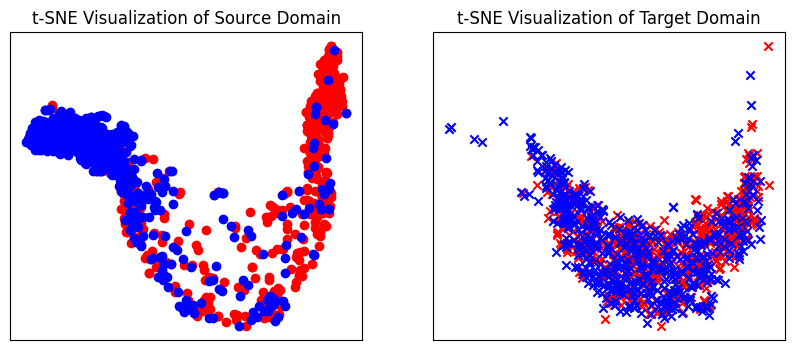

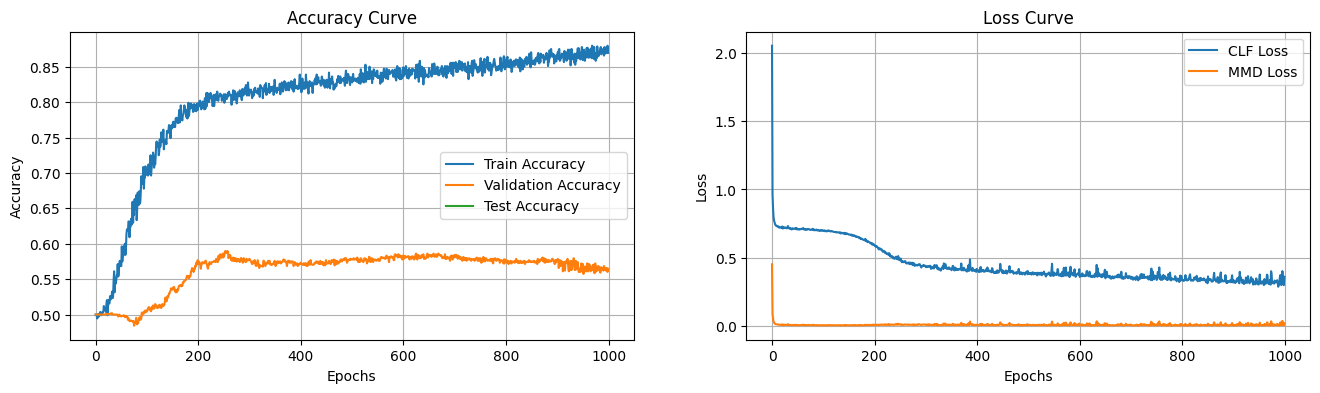

In [ ]:
model = EEGNet_DAN(num_classes=2)
source_data, source_label, val_data, val_label, target_data, target_label = read_bci_data()
train(model, source_data, source_label, val_data, val_label, target_data, target_label, lambda_factor=3, batch_size=1080, epochs=1000, lr=1e-2, path='DAN.jpg')
# 发现：加入MK-MMD(gaussian kernels)收敛会变困难?

### JAN

torch.Size([1080, 1, 2, 750]) torch.Size([1080]) torch.Size([1080, 1, 2, 750]) torch.Size([1080]) torch.Size([1080, 1, 2, 750]) torch.Size([1080])


  0%|          | 2/1000 [00:00<04:17,  3.87it/s]

Model saved at epoch 1 with validation accuracy: 0.5000


  3%|▎         | 28/1000 [00:05<03:11,  5.07it/s]

Model saved at epoch 27 with validation accuracy: 0.5019
Model saved at epoch 28 with validation accuracy: 0.5037


  4%|▎         | 36/1000 [00:07<03:08,  5.10it/s]

Model saved at epoch 35 with validation accuracy: 0.5065


  6%|▌         | 57/1000 [00:11<03:08,  5.01it/s]

Model saved at epoch 57 with validation accuracy: 0.5074


  6%|▌         | 59/1000 [00:11<03:06,  5.03it/s]

Model saved at epoch 58 with validation accuracy: 0.5407


 10%|█         | 102/1000 [00:20<02:57,  5.07it/s]

Model saved at epoch 101 with validation accuracy: 0.5426


 19%|█▉        | 189/1000 [00:37<02:45,  4.89it/s]

Model saved at epoch 189 with validation accuracy: 0.5565


 19%|█▉        | 191/1000 [00:37<02:44,  4.92it/s]

Model saved at epoch 190 with validation accuracy: 0.5685


 20%|██        | 205/1000 [00:40<02:38,  5.02it/s]

Model saved at epoch 205 with validation accuracy: 0.5704


 28%|██▊       | 285/1000 [00:56<02:22,  5.03it/s]

Model saved at epoch 206 with validation accuracy: 0.5806
Model saved at epoch 284 with validation accuracy: 0.5833
Model saved at epoch 285 with validation accuracy: 0.5954


 31%|███       | 308/1000 [01:01<02:16,  5.08it/s]

Model saved at epoch 307 with validation accuracy: 0.5963


 34%|███▍      | 344/1000 [01:08<02:09,  5.06it/s]

Model saved at epoch 343 with validation accuracy: 0.6028


 81%|████████  | 810/1000 [02:40<00:38,  4.98it/s]

Model saved at epoch 809 with validation accuracy: 0.6037


100%|██████████| 1000/1000 [03:17<00:00,  5.07it/s]


the best accuracy is:  0.6037037037037037
(1080, 256) (1080, 256)
(2160, 256)
(1080, 2) (1080, 2)
(540, 2) (540, 2) (540, 2) (540, 2)


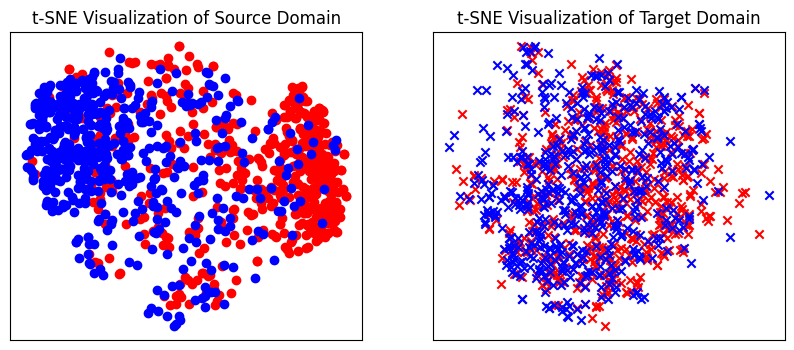

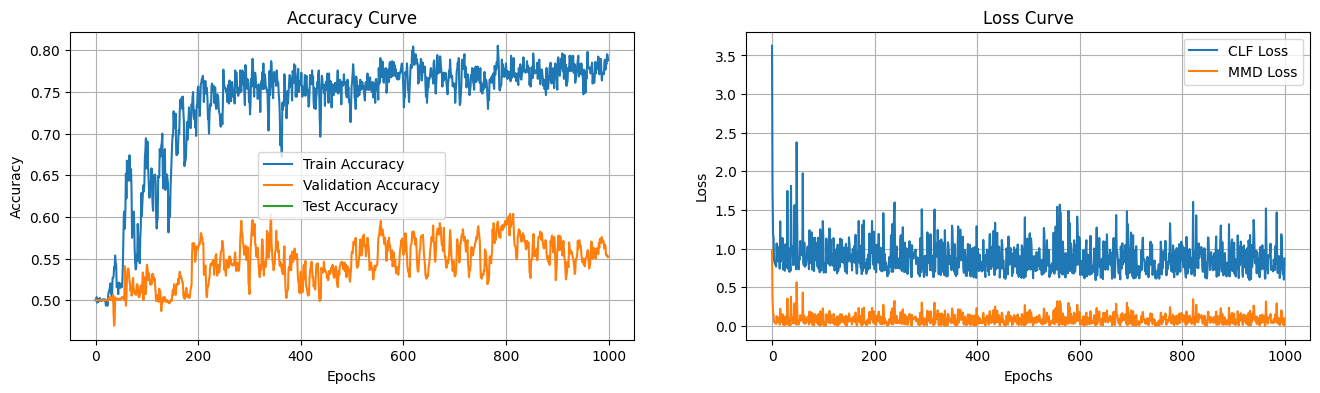

In [ ]:
model = EEGNet_JAN(num_classes=2)
source_data, source_label, val_data, val_label, target_data, target_label = read_bci_data()
train(model, source_data, source_label, val_data, val_label, target_data, target_label, lambda_factor=3, batch_size=1080, epochs=1000, lr=1e-2, path='JAN', format='jpg')

# DJP-MMD

In [70]:
# MMD, JMMD, JPMMD, DJP-MMD
def mmd_loss(x_src, y_src, x_tar, y_pseudo, mmd_type):
    if mmd_type == 'mmd':
        return rbf_mmd(x_src, x_tar, SIGMA)
    elif mmd_type == 'jmmd':
        return rbf_jmmd(x_src, y_src, x_tar, y_pseudo, SIGMA)
    elif mmd_type == 'jpmmd':
        return rbf_jpmmd(x_src, y_src, x_tar, y_pseudo, SIGMA)
    elif mmd_type == 'djpmmd':
        return rbf_djpmmd(x_src, y_src, x_tar, y_pseudo, SIGMA)


def test(data, label, model):
    model.eval()
    with torch.no_grad():
        data, label = data.to(DEVICE), label.to(DEVICE)
        pred, _, _ = model(data, data)

        correct_cnt = (torch.max(pred, 1)[1] == label).sum().item()
        sample_cnt = data.shape[0]
        accuracy = correct_cnt / sample_cnt

    return accuracy

def train(model, source_data, source_label, val_data, val_label, target_data, target_label, lambda_factor=0.5, batch_size=1080, epochs=500, lr=1e-3, path='test', format='jpg'):
    train_dataset = TensorDataset(source_data, source_label)
    val_dataset = TensorDataset(val_data, val_label)

    train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(dataset=val_dataset, batch_size=batch_size, shuffle=True)

    loss_fn = nn.CrossEntropyLoss()

    optimizer = optim.Adam(model.parameters(),lr = lr)
    # optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.5, weight_decay=5e-4)

    model.to(DEVICE)

    mmd_type = 'djpmmd'
    y_pse = torch.zeros(1080).long().cuda()

    clf_loss_history = []
    mmd_loss_history = []
    train_accuracy_history = []
    val_accuracy_history = []
    test_accuracy_history = []

    best_acc = 0

    for epoch in tqdm(range(epochs)):
        model.train()

        optimizer.zero_grad()

        source_data, source_label = source_data.to(DEVICE), source_label.to(DEVICE)
        target_data = target_data.to(DEVICE)
        val_data = val_data.to(DEVICE)

        y_src, features_src, features_tar = model(source_data, val_data)
        # print("fshj", y_src.shape)
        # print(len(torch.unique(y_src)))

        # compute loss
        clf_loss = loss_fn(y_src, source_label)
        loss_mmd = mmd_loss(features_src, source_label.long(), features_tar, y_pse, mmd_type) # use true lable in the source domain to compute loss
        loss = clf_loss + lambda_factor * loss_mmd

        model.eval()
        y_pse, _, _ = model(val_data, val_data)
        y_pse = y_pse.detach().max(1)[1]

        clf_loss_history.append(loss.item())
        mmd_loss_history.append(loss_mmd.item())

        correct_cnt = (torch.max(y_src, 1)[1] == source_label).sum().item()
        accuracy = correct_cnt / source_data.shape[0]
        train_accuracy_history.append(accuracy)

        loss.backward()
        optimizer.step()

        val_accuracy = test(val_data, val_label, model)
        val_accuracy_history.append(val_accuracy)
        if val_accuracy > best_acc:
            best_acc = val_accuracy
            torch.save(model.state_dict(), 'DA_best_model.pth')
            print(f'Model saved at epoch {epoch+1} with validation accuracy: {val_accuracy:.4f}')


    print("the best accuracy is: ", best_acc)
    model.load_state_dict(torch.load("DA_best_model.pth"))
    _, source_features, val_features = model(source_data.to(DEVICE), val_data.to(DEVICE))
    tsne_visulization(source_features.cpu().detach().numpy(), val_features.cpu().detach().numpy(), path='original.jpg')

    plt.figure(figsize=(16, 4))
    plt.subplot(1, 2, 1)
    # plt.plot(loss_history, label="Loss")
    plt.plot(train_accuracy_history, label='Train Accuracy')
    plt.plot(val_accuracy_history, label='Validation Accuracy')
    plt.plot(test_accuracy_history, label='Test Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.title('Accuracy Curve')
    plt.grid(True)
    # plt.show()


    plt.subplot(1, 2, 2)
    plt.plot(clf_loss_history, label="CLF Loss")
    plt.plot(mmd_loss_history, label='MMD Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Loss Curve')
    plt.grid(True)
    plt.show()

torch.Size([1080, 1, 2, 750]) torch.Size([1080]) torch.Size([1080, 1, 2, 750]) torch.Size([1080]) torch.Size([1080, 1, 2, 750]) torch.Size([1080])


  0%|          | 1/1000 [00:00<05:25,  3.07it/s]

Model saved at epoch 1 with validation accuracy: 0.5000


  2%|▏         | 19/1000 [00:04<03:33,  4.60it/s]

Model saved at epoch 19 with validation accuracy: 0.5778


  5%|▌         | 50/1000 [00:10<03:20,  4.73it/s]

Model saved at epoch 50 with validation accuracy: 0.5787


  5%|▌         | 51/1000 [00:11<03:21,  4.71it/s]

Model saved at epoch 51 with validation accuracy: 0.6222


  8%|▊         | 78/1000 [00:16<03:16,  4.68it/s]

Model saved at epoch 78 with validation accuracy: 0.6241


  8%|▊         | 83/1000 [00:17<03:14,  4.72it/s]

Model saved at epoch 83 with validation accuracy: 0.6287


  9%|▉         | 92/1000 [00:19<03:11,  4.74it/s]

Model saved at epoch 92 with validation accuracy: 0.6315


100%|██████████| 1000/1000 [03:30<00:00,  4.74it/s]


the best accuracy is:  0.6314814814814815
(1080, 256) (1080, 256)
(2160, 256)
(1080, 2) (1080, 2)
(540, 2) (540, 2) (540, 2) (540, 2)


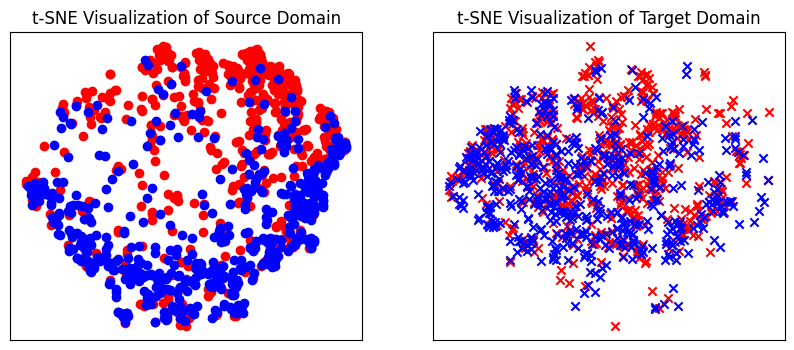

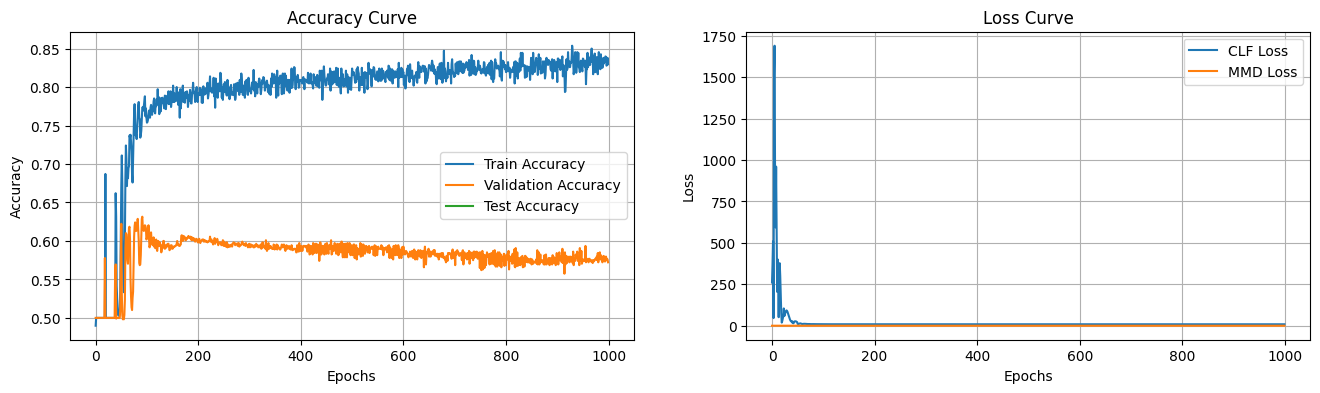

In [72]:
model = EEGNet_DA1(n_output=2)
source_data, source_label, val_data, val_label, target_data, target_label = read_bci_data()
train(model, source_data, source_label, val_data, val_label, target_data, target_label, lambda_factor=10000, batch_size=1080, epochs=1000, lr=1e-1, path='DJPMMD', format='jpg')

## TCA

In [ ]:
import numpy as np
import scipy.io
import scipy.linalg
import sklearn.metrics
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split


def kernel(ker, X1, X2, gamma):
    K = None
    if not ker or ker == 'primal':
        K = X1
    elif ker == 'linear':
        if X2 is not None:
            K = sklearn.metrics.pairwise.linear_kernel(
                np.asarray(X1).T, np.asarray(X2).T)
        else:
            K = sklearn.metrics.pairwise.linear_kernel(np.asarray(X1).T)
    elif ker == 'rbf':
        if X2 is not None:
            K = sklearn.metrics.pairwise.rbf_kernel(
                np.asarray(X1).T, np.asarray(X2).T, gamma)
        else:
            K = sklearn.metrics.pairwise.rbf_kernel(
                np.asarray(X1).T, None, gamma)
    return K


class TCA:
    def __init__(self, kernel_type='primal', dim=30, lamb=1, gamma=1):
        '''
        Init func
        :param kernel_type: kernel, values: 'primal' | 'linear' | 'rbf'
        :param dim: dimension after transfer
        :param lamb: lambda value in equation
        :param gamma: kernel bandwidth for rbf kernel
        '''
        self.kernel_type = kernel_type
        self.dim = dim
        self.lamb = lamb
        self.gamma = gamma

    def fit(self, Xs, Xt):
        '''
        Transform Xs and Xt
        :param Xs: ns * n_feature, source feature
        :param Xt: nt * n_feature, target feature
        :return: Xs_new and Xt_new after TCA
        '''
        X = np.hstack((Xs.T, Xt.T))
        X /= np.linalg.norm(X, axis=0)
        m, n = X.shape
        ns, nt = len(Xs), len(Xt)
        e = np.vstack((1 / ns * np.ones((ns, 1)), -1 / nt * np.ones((nt, 1))))
        M = e * e.T
        M = M / np.linalg.norm(M, 'fro')
        H = np.eye(n) - 1 / n * np.ones((n, n))
        K = kernel(self.kernel_type, X, None, gamma=self.gamma)
        n_eye = m if self.kernel_type == 'primal' else n
        a, b = K @ M @ K.T + self.lamb * np.eye(n_eye), K @ H @ K.T
        w, V = scipy.linalg.eig(a, b)
        ind = np.argsort(w)
        A = V[:, ind[:self.dim]]
        Z = A.T @ K
        Z /= np.linalg.norm(Z, axis=0)

        Xs_new, Xt_new = Z[:, :ns].T, Z[:, ns:].T
        return Xs_new, Xt_new

    def fit_predict(self, Xs, Ys, Xt, Yt):
        '''
        Transform Xs and Xt, then make predictions on target using 1NN
        :param Xs: ns * n_feature, source feature
        :param Ys: ns * 1, source label
        :param Xt: nt * n_feature, target feature
        :param Yt: nt * 1, target label
        :return: Accuracy and predicted_labels on the target domain
        '''
        Xs_new, Xt_new = self.fit(Xs, Xt)
        clf = KNeighborsClassifier(n_neighbors=1)
        clf.fit(Xs_new, Ys.ravel())
        y_pred = clf.predict(Xt_new)
        acc = sklearn.metrics.accuracy_score(Yt, y_pred)

        return acc, y_pred

    # TCA code is done here. You can ignore fit_new and fit_predict_new.

    def fit_new(self, Xs, Xt, Xt2):
        '''
        Map Xt2 to the latent space created from Xt and Xs
        :param Xs : ns * n_feature, source feature
        :param Xt : nt * n_feature, target feature
        :param Xt2: n_s, n_feature, target feature to be mapped
        :return: Xt2_new, mapped Xt2 with projection created by Xs and Xt
        '''
        # Computing projection matrix A from Xs an Xt
        X = np.hstack((Xs.T, Xt.T))
        X /= np.linalg.norm(X, axis=0)
        m, n = X.shape
        ns, nt = len(Xs), len(Xt)
        e = np.vstack((1 / ns * np.ones((ns, 1)), -1 / nt * np.ones((nt, 1))))
        M = e * e.T
        M = M / np.linalg.norm(M, 'fro')
        H = np.eye(n) - 1 / n * np.ones((n, n))
        K = kernel(self.kernel_type, X, None, gamma=self.gamma)
        n_eye = m if self.kernel_type == 'primal' else n
        a, b = np.linalg.multi_dot(
            [K, M, K.T]) + self.lamb * np.eye(n_eye), np.linalg.multi_dot([K, H, K.T])
        w, V = scipy.linalg.eig(a, b)
        ind = np.argsort(w)
        A = V[:, ind[:self.dim]]

        # Compute kernel with Xt2 as target and X as source
        Xt2 = Xt2.T
        K = kernel(self.kernel_type, X1=Xt2, X2=X, gamma=self.gamma)

        # New target features
        Xt2_new = K @ A

        return Xt2_new

    def fit_predict_new(self, Xt, Xs, Ys, Xt2, Yt2):
        '''
        Transfrom Xt and Xs, get Xs_new
        Transform Xt2 with projection matrix created by Xs and Xt, get Xt2_new
        Make predictions on Xt2_new using classifier trained on Xs_new
        :param Xt: ns * n_feature, target feature
        :param Xs: ns * n_feature, source feature
        :param Ys: ns * 1, source label
        :param Xt2: nt * n_feature, new target feature
        :param Yt2: nt * 1, new target label
        :return: Accuracy and predicted_labels on the target domain
        '''
        Xs_new, _ = self.fit(Xs, Xt)
        Xt2_new = self.fit_new(Xs, Xt, Xt2)
        clf = KNeighborsClassifier(n_neighbors=1)
        clf.fit(Xs_new, Ys.ravel())
        y_pred = clf.predict(Xt2_new)
        acc = sklearn.metrics.accuracy_score(Yt2, y_pred)

        return acc, y_pred


def train_valid(source_data, source_lable, val_data, val_label, target_data, target_label):

    source_data, val_data, target_data = source_data.reshape(source_data.shape[0], -1), val_data.reshape(val_data.shape[0], -1), target_data.reshape(target_data.shape[0], -1)

    # Create latent space and evaluate using Xs and Xt1
    tca = TCA(kernel_type='linear', dim=30, lamb=1, gamma=1)
    acc1, ypre1 = tca.fit_predict(source_data, source_label, val_data, val_label)

    # Project and evaluate Xt2 existing projection matrix and classifier
    acc2, ypre2 = tca.fit_predict_new(val_data, source_data, source_label, target_data, target_label)

    print(f'Accuracy of mapped source and target1 data : {acc1:.3f}')  # 0.800
    print(f'Accuracy of mapped target2 data            : {acc2:.3f}')  # 0.706




In [ ]:
train_valid(source_data, source_label, val_data, val_label, target_data, target_label)

In [ ]:
tca = TCA(kernel_type='linear', dim=30, lamb=1, gamma=1)
acc, ypred = tca.fit_predict(source_data, source_label, target_data, target_label)
print(f'Accuracy: {acc:.3f}')

## DaNN